In [1]:
import sys
sys.path.append("../src")
sys.path.append("../models")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from tqdm.notebook import tqdm as tqdm_notebook
from catboost import CatBoostClassifier, CatBoostRegressor
from xgboost import XGBClassifier
from pycaret.classification import *
from sklearn.metrics import f1_score, mean_squared_error

# custom functions
import config
from helpers import preprocessing
from automl import get_pycaret_model

# V1. Code
* Ordinal Encoding과 Onehot Encoding을 섞어서 진행
* missing values는 Simple Impute로 진행
* 추가적인 변수 생성은 없음. (V2에서 실험)

In [2]:
train = pd.read_csv(config.TRAINING_FILE)
test = pd.read_csv(config.TEST_FILE)
origin = pd.read_csv(config.ORIGINAL_FILE)

In [3]:
train = train.replace('None', np.NaN)
test = test.replace('None', np.NaN)
origin = origin.replace('None', np.NaN)

In [4]:
categorical_cols = ['temp_of_extremities', 'peripheral_pulse', 'mucous_membrane','capillary_refill_time','pain',
'peristalsis','abdominal_distention','nasogastric_tube','nasogastric_reflux','rectal_exam_feces','abdomen',
'abdomo_appearance','lesion_2','surgery', 'age', 'surgical_lesion', 'lesion_3', 'cp_data']
numerical_cols = list(set(train.columns) - set(categorical_cols) - set(["id"]))

In [5]:
print(f"TRAIN SHAPE : {train.shape}")
print(f"TEST SHAPE : {test.shape}")
print(f"ORIGINAL SHAPE : {origin.shape}")

TRAIN SHAPE : (1235, 29)
TEST SHAPE : (824, 28)
ORIGINAL SHAPE : (299, 28)


In [6]:
# concate training and original data
train = pd.concat(
    [train, origin], ignore_index=True
)
train = train.drop_duplicates().drop(['id'], axis=1)
print(train.shape)

(1534, 28)


## missing value
* Simple Impute

In [7]:
# 한 row에 missing value가 10개 넘는 것들은 제거

missing_values_per_row = train.isna().sum(axis=1)
print(train.shape)
threshold = 10
train = train[missing_values_per_row <= threshold]
print(train.shape)
train=train.reset_index(drop=True)

(1534, 28)
(1503, 28)


In [16]:
missing_cat=[f for f in train.columns if train[f].dtype=="O" and train[f].isna().sum()>0]
train_missing_pct = train[missing_cat].isnull().mean() * 100
test_missing_pct = test[missing_cat].isnull().mean() * 100

missing_pct_df = pd.concat([train_missing_pct, test_missing_pct], axis=1, keys=['Train %', 'Test%'])
print(missing_pct_df)

                         Train %      Test%
temp_of_extremities     4.136091   4.247573
peripheral_pulse        6.404270   5.703883
mucous_membrane         2.601734   1.577670
capillary_refill_time   1.000667   0.728155
pain                    4.669780   3.519417
peristalsis             2.201468   2.305825
abdominal_distention   22.348232  20.995146
nasogastric_tube       33.155437  27.791262
nasogastric_reflux     36.157438  29.004854
rectal_exam_feces      17.278185  15.169903
abdomen                20.013342  18.689320
abdomo_appearance      12.208139   3.762136


In [17]:
# cat_params={
#             'depth': 6,
#             'learning_rate': 0.1,
#             'l2_leaf_reg': 0.7,
#             'random_strength': 0.2,
#             'max_bin': 200,
#             'od_wait': 65,
#             'one_hot_max_size': 70,
#             'grow_policy': 'Depthwise',
#             'bootstrap_type': 'Bayesian',
#             'od_type': 'Iter',
#             'eval_metric': 'MultiClass',
#             'loss_function': 'MultiClass',
# }
# def store_missing_rows(df, features):
#     missing_rows = {}
    
#     for feature in features:
#         missing_rows[feature] = df[df[feature].isnull()]
    
#     return missing_rows

# def fill_missing_categorical(train, test, target, features, max_iterations=10):
#     df = pd.concat([train.drop(columns=target), test], axis="rows")
#     df = df.reset_index(drop=True)

#     # Step 1: Store the instances with missing values in each feature
#     missing_rows = store_missing_rows(df, features)

#     # Step 2: Initially fill all missing values with "Missing"
#     for f in features:
#         df[f] = df[f].fillna("Missing_" + f)

#     for iteration in tqdm(range(max_iterations), desc="Iterations"):
#         for feature in features:
#             # Skip features with no missing values
#             rows_miss = missing_rows[feature].index

#             missing_temp = df.loc[rows_miss].copy()
#             non_missing_temp = df.drop(index=rows_miss).copy()
#             missing_temp = missing_temp.drop(columns=[feature])

#             other_features = [x for x in df.columns if x != feature and df[x].dtype == "O"]

#             X_train = non_missing_temp.drop(columns=[feature])
#             y_train = non_missing_temp[[feature]]

#             catboost_classifier = CatBoostClassifier(**cat_params)
#             catboost_classifier.fit(X_train, y_train, cat_features=other_features, verbose=False)

#             # Step 4: Predict missing values for the feature and update all N features
#             y_pred = catboost_classifier.predict(missing_temp)
            
#             # Convert y_pred to strings if necessary
#             if y_pred.dtype != "O":
#                 y_pred = y_pred.astype(str)

#             df.loc[rows_miss, feature] = y_pred

#     train[features] = np.array(df.iloc[:train.shape[0]][features])
#     test[features] = np.array(df.iloc[train.shape[0]:][features])

#     return train, test

# train, test = fill_missing_categorical(train, test, "outcome", missing_cat, 5)

In [18]:
missing_num=[f for f in train.columns if train[f].dtype!="O" and train[f].isna().sum()>0]
train_missing_pct = train[missing_num].isnull().mean() * 100
test_missing_pct = test[missing_num].isnull().mean() * 100
missing_pct_df = pd.concat([train_missing_pct, test_missing_pct], axis=1, keys=['Train %', 'Test%'])
print(missing_pct_df)

                         Train %  Test%
rectal_temp             3.068712    0.0
pulse                   0.933956    0.0
respiratory_rate        3.002001    0.0
nasogastric_reflux_ph  14.142762    0.0
packed_cell_volume      0.933956    0.0
total_protein           1.200801    0.0
abdomo_protein         11.274183    0.0


In [19]:
# cb_params = {
#             'iterations': 500,
#             'depth': 6,
#             'learning_rate': 0.02,
#             'l2_leaf_reg': 0.5,
#             'random_strength': 0.2,
#             'max_bin': 150,
#             'od_wait': 80,
#             'one_hot_max_size': 70,
#             'grow_policy': 'Depthwise',
#             'bootstrap_type': 'Bayesian',
#             'od_type': 'IncToDec',
#             'eval_metric': 'RMSE',
#             'loss_function': 'RMSE',
#             'random_state': 42,
#         }
# def rmse(y1,y2):
#     return(np.sqrt(mean_squared_error(y1,y2)))

# def fill_missing_numerical(train,test,target, features, max_iterations=10):
#     train_temp=train.copy()
#     if target in train_temp.columns:
#         train_temp=train_temp.drop(columns=target)
        
    
#     df=pd.concat([train_temp,test],axis="rows")
#     df=df.reset_index(drop=True)
    
#     # Step 1: Store the instances with missing values in each feature
#     missing_rows = store_missing_rows(df, features)
    
#     # Step 2: Initially fill all missing values with "Missing"
#     for f in features:
#         df[f]=df[f].fillna(df[f].mean())
    
#     cat_features=[f for f in df.columns if not pd.api.types.is_numeric_dtype(df[f])]
#     dictionary = {feature: [] for feature in features}
    
#     for iteration in tqdm(range(max_iterations), desc="Iterations"):
#         for feature in features:
#             # Skip features with no missing values
#             rows_miss = missing_rows[feature].index
            
#             missing_temp = df.loc[rows_miss].copy()
#             non_missing_temp = df.drop(index=rows_miss).copy()
#             y_pred_prev=missing_temp[feature]
#             missing_temp = missing_temp.drop(columns=[feature])
            
            
#             # Step 3: Use the remaining features to predict missing values using Random Forests
#             X_train = non_missing_temp.drop(columns=[feature])
#             y_train = non_missing_temp[[feature]]
            
#             catboost_classifier = CatBoostRegressor(**cb_params)
#             catboost_classifier.fit(X_train, y_train,cat_features=cat_features, verbose=False)
            
#             # Step 4: Predict missing values for the feature and update all N features
#             y_pred = catboost_classifier.predict(missing_temp)
#             df.loc[rows_miss, feature] = y_pred
#             error_minimize=rmse(y_pred,y_pred_prev)
#             dictionary[feature].append(error_minimize)  # Append the error_minimize value

#     for feature, values in dictionary.items():
#         iterations = range(1, len(values) + 1)  # x-axis values (iterations)
#         plt.plot(iterations, values, label=feature)  # plot the values
#         plt.xlabel('Iterations')
#         plt.ylabel('RMSE')
#         plt.title('Minimization of RMSE with iterations')
#         plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.show()
#     train[features] = np.array(df.iloc[:train.shape[0]][features])
#     test[features] = np.array(df.iloc[train.shape[0]:][features])

#     return train,test

# train,test = fill_missing_numerical(train,test,"outcome",missing_num,5)

## Encoding
* Imputation은 우선은 mode로 진행해보기

In [8]:
train["Source"] = ["Train"] * len(train)
test["Source"] = ["Test"] * len(test)

df_all = pd.concat(
    [train, test], ignore_index=True
)

print(df_all.shape)
df_all.head()

(2327, 30)


,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome,Source,id
0,yes,adult,530001,38.1,132.0,24.0,cool,reduced,dark_cyanotic,more_3_sec,...,serosanguious,3.4,yes,2209,0,0,no,died,Train,NaN
1,yes,adult,533836,37.5,88.0,12.0,cool,normal,pale_cyanotic,more_3_sec,...,serosanguious,2.0,yes,2208,0,0,no,euthanized,Train,NaN
2,yes,adult,529812,38.3,120.0,28.0,cool,reduced,pale_pink,less_3_sec,...,serosanguious,3.4,yes,5124,0,0,no,lived,Train,NaN
3,yes,adult,5262541,37.1,72.0,30.0,cold,reduced,pale_pink,more_3_sec,...,cloudy,3.9,yes,2208,0,0,yes,lived,Train,NaN
4,no,adult,5299629,38.0,52.0,48.0,normal,normal,normal_pink,less_3_sec,...,cloudy,2.6,no,0,0,0,yes,lived,Train,NaN


In [9]:
from scipy import stats

def chi_squared_test(df, input_var, target_var, significance_level=0.05):
    contingency_table = pd.crosstab(df[input_var], df[target_var])
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
    if p < significance_level:
        print(f'\033[32m{input_var} has a significant relationship with the target variable.\033[0m') 
    else:
        print(f'\033[31m{input_var} does not have a significant relationship with the target variable.\033[0m')  

for i in categorical_cols:
    chi_squared_test(train, i, 'outcome')

temp_of_extremities has a significant relationship with the target variable.
peripheral_pulse has a significant relationship with the target variable.
mucous_membrane has a significant relationship with the target variable.
capillary_refill_time has a significant relationship with the target variable.
pain has a significant relationship with the target variable.
peristalsis has a significant relationship with the target variable.
abdominal_distention has a significant relationship with the target variable.
nasogastric_tube has a significant relationship with the target variable.
nasogastric_reflux has a significant relationship with the target variable.
rectal_exam_feces has a significant relationship with the target variable.
abdomen has a significant relationship with the target variable.
abdomo_appearance has a significant relationship with the target variable.
lesion_2 has a significant relationship with the target variable.
surgery has a significant relationship with the target va

In [10]:
train.drop('lesion_3',axis=1,inplace=True)
# test.drop('lesion_3', axis=1, inplace=True)
categorical_cols.remove('lesion_3')

In [11]:
le_cols = ['surgery', 'age', 'surgical_lesion', 'cp_data']
ohe_cols = ['mucous_membrane']

train = preprocessing(train, le_cols, ohe_cols)
test = preprocessing(test, le_cols, ohe_cols)

In [12]:
def features_engineering(df : pd.DataFrame):
    _df = df.copy()
    
    # Imputer
    cols_with_nan = (df.drop('outcome', axis=1)
                     .columns[df.drop('outcome', axis=1).isna().any()]
                     .tolist())
    for feature in cols_with_nan:
        _df[feature].fillna(_df[feature].mode()[0], inplace=True) # 최빈값으로 입력
        
    return _df

train = features_engineering(train)

In [13]:
baseline_best_model = get_pycaret_model(train, "outcome")

,Description,Value
0,Session id,2636
1,Target,outcome
2,Target type,Multiclass
3,Target mapping,"died: 0, euthanized: 1, lived: 2"
4,Original data shape,"(1503, 33)"
5,Transformed data shape,"(1503, 33)"
6,Transformed train set shape,"(1052, 33)"
7,Transformed test set shape,"(451, 33)"
8,Numeric features,31
9,Categorical features,1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.7357,0.8665,0.7357,0.7398,0.7324,0.5708,0.5740,0.1020
xgboost,Extreme Gradient Boosting,0.7348,0.8760,0.7348,0.7361,0.7330,0.5707,0.5724,0.1820
gbc,Gradient Boosting Classifier,0.7347,0.8771,0.7347,0.7352,0.7322,0.5698,0.5714,0.2060
catboost,CatBoost Classifier,0.7329,0.8759,0.7329,0.7339,0.7289,0.5649,0.5677,1.1240
lightgbm,Light Gradient Boosting Machine,0.7319,0.8782,0.7319,0.7348,0.7299,0.5647,0.5669,1.8420
et,Extra Trees Classifier,0.7081,0.8531,0.7081,0.7117,0.7022,0.5229,0.5273,0.0840
ada,Ada Boost Classifier,0.6872,0.7798,0.6872,0.6860,0.6845,0.4931,0.4945,0.0460
ridge,Ridge Classifier,0.6587,0.0000,0.6587,0.6599,0.6518,0.4416,0.4458,0.0240
lda,Linear Discriminant Analysis,0.6482,0.8156,0.6482,0.6497,0.6456,0.4330,0.4353,0.0320
dt,Decision Tree Classifier,0.5913,0.6716,0.5913,0.5921,0.5903,0.3430,0.3437,0.0300


In [14]:
baseline_best_model.feature_names_in_

array(['surgery', 'age', 'hospital_number', 'rectal_temp', 'pulse',
       'respiratory_rate', 'temp_of_extremities', 'peripheral_pulse',
       'capillary_refill_time', 'pain', 'peristalsis',
       'abdominal_distention', 'nasogastric_tube', 'nasogastric_reflux',
       'nasogastric_reflux_ph', 'rectal_exam_feces', 'abdomen',
       'packed_cell_volume', 'total_protein', 'abdomo_appearance',
       'abdomo_protein', 'surgical_lesion', 'lesion_1', 'lesion_2',
       'cp_data', 'Source_Train', 'mucous_membrane_bright_pink',
       'mucous_membrane_bright_red', 'mucous_membrane_dark_cyanotic',
       'mucous_membrane_normal_pink', 'mucous_membrane_pale_cyanotic',
       'mucous_membrane_pale_pink'], dtype=object)

In [15]:
best_features = (pd.DataFrame(baseline_best_model.feature_importances_,
                             index = baseline_best_model.feature_names_in_) # change variables
                 .sort_values(0, ascending=False)
                 .head(30)
                 .index
                 .values
                 .tolist()
                 )
best_features.append("outcome")
best_features

['pulse',
 'total_protein',
 'hospital_number',
 'packed_cell_volume',
 'lesion_1',
 'abdomo_protein',
 'nasogastric_reflux_ph',
 'pain',
 'respiratory_rate',
 'rectal_temp',
 'peripheral_pulse',
 'abdominal_distention',
 'abdomo_appearance',
 'temp_of_extremities',
 'surgical_lesion',
 'rectal_exam_feces',
 'abdomen',
 'capillary_refill_time',
 'nasogastric_reflux',
 'peristalsis',
 'mucous_membrane_normal_pink',
 'nasogastric_tube',
 'surgery',
 'cp_data',
 'mucous_membrane_pale_cyanotic',
 'mucous_membrane_pale_pink',
 'mucous_membrane_bright_red',
 'mucous_membrane_dark_cyanotic',
 'mucous_membrane_bright_pink',
 'age',
 'outcome']

In [17]:
baseline_best_model = get_pycaret_model(train[best_features], "outcome")

,Description,Value
0,Session id,8349
1,Target,outcome
2,Target type,Multiclass
3,Target mapping,"died: 0, euthanized: 1, lived: 2"
4,Original data shape,"(1503, 31)"
5,Transformed data shape,"(1503, 31)"
6,Transformed train set shape,"(1052, 31)"
7,Transformed test set shape,"(451, 31)"
8,Numeric features,30
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7291,0.8675,0.7291,0.7282,0.7253,0.5563,0.5588,0.1560
catboost,CatBoost Classifier,0.7272,0.8634,0.7272,0.7280,0.7251,0.5566,0.5583,0.8380
lightgbm,Light Gradient Boosting Machine,0.7253,0.8651,0.7253,0.7256,0.7240,0.5545,0.5555,0.4740
xgboost,Extreme Gradient Boosting,0.7196,0.8629,0.7196,0.7190,0.7182,0.5463,0.5471,0.1160
rf,Random Forest Classifier,0.7139,0.8623,0.7139,0.7129,0.7096,0.5326,0.5350,0.0740
et,Extra Trees Classifier,0.7005,0.8544,0.7005,0.7007,0.6971,0.5119,0.5141,0.0580
ada,Ada Boost Classifier,0.6825,0.7929,0.6825,0.6822,0.6799,0.4876,0.4891,0.0300
ridge,Ridge Classifier,0.6303,0.0000,0.6303,0.6297,0.6248,0.3942,0.3966,0.0060
lda,Linear Discriminant Analysis,0.6236,0.7963,0.6236,0.6237,0.6205,0.3901,0.3917,0.0100
qda,Quadratic Discriminant Analysis,0.6093,0.7765,0.6093,0.6236,0.6129,0.3876,0.3903,0.0080


### 결과 정리

XGB - Full Dataset : 0.7330  
GBC - Best30 Dataset : 0.7253 
~~~
Full Dataset Top Score : 0.7330  (Non-Tuning)
Best Feature Dataset Top Score : 0.7253 (Non-Tuning)


### Model Tuning

In [13]:
s = setup(data = train, target = 'outcome', fold=5)
top3_best_models = compare_models(fold=5, sort="F1", n_select=3)

,Description,Value
0,Session id,1011
1,Target,outcome
2,Target type,Multiclass
3,Target mapping,"died: 0, euthanized: 1, lived: 2"
4,Original data shape,"(1503, 33)"
5,Transformed data shape,"(1503, 33)"
6,Transformed train set shape,"(1052, 33)"
7,Transformed test set shape,"(451, 33)"
8,Numeric features,31
9,Categorical features,1


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7215,0.8602,0.7215,0.7254,0.7196,0.5487,0.5516,0.2000
xgboost,Extreme Gradient Boosting,0.7139,0.8582,0.7139,0.7176,0.7122,0.5367,0.5398,0.0640
lightgbm,Light Gradient Boosting Machine,0.7139,0.8625,0.7139,0.7162,0.7117,0.5340,0.5366,0.5080
catboost,CatBoost Classifier,0.7129,0.8556,0.7129,0.7175,0.7117,0.5354,0.5380,1.0020
rf,Random Forest Classifier,0.7091,0.8565,0.7091,0.7169,0.7074,0.5305,0.5344,0.0820
et,Extra Trees Classifier,0.6787,0.8415,0.6787,0.6850,0.6757,0.4765,0.4802,0.0700
ada,Ada Boost Classifier,0.6673,0.7939,0.6673,0.6679,0.6642,0.4588,0.4610,0.0460
lda,Linear Discriminant Analysis,0.6379,0.7945,0.6379,0.6416,0.6354,0.4136,0.4160,0.0240
ridge,Ridge Classifier,0.6322,0.0000,0.6322,0.6360,0.6266,0.3978,0.4017,0.0160
dt,Decision Tree Classifier,0.6141,0.6860,0.6141,0.6143,0.6124,0.3766,0.3778,0.0220


Top 3 Baseline Model - Catboost, XGBoost, LightGBM  
* But Catboost cannot blended (Error) -> 다음에는 Catboost 제외 하고 top N 으로 추려서 Ensemble

In [14]:
models = {
    'catboost' : create_model("catboost", fold=5),
    'xgboost' : create_model("xgboost", fold=5),
    'lightgbm' : create_model("lightgbm", fold=5)
}

for model_name, model in models.items():
    try:
        models[model_name] = tune_model(model, 
                                        optimize="F1",
                                        fold=5,
                                        search_library="optuna")
        
    except:
        models[model_name] = tune_model(model, 
                                        optimize="F1",
                                        fold=5,
                                        search_library="scikit-learn")

# catboost can't blended -> blacklist['catboost']

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7156,0.8578,0.7156,0.7167,0.7157,0.5407,0.5410
1,0.6967,0.8370,0.6967,0.6994,0.6963,0.5152,0.5166
2,0.7095,0.8491,0.7095,0.7110,0.7041,0.5160,0.5210
3,0.7524,0.8771,0.7524,0.7674,0.7508,0.5993,0.6053
4,0.6905,0.8569,0.6905,0.6932,0.6916,0.5059,0.5062
Mean,0.7129,0.8556,0.7129,0.7175,0.7117,0.5354,0.5380
Std,0.0216,0.0131,0.0216,0.0263,0.0212,0.0340,0.0355


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7109,0.8587,0.7109,0.7115,0.7112,0.5356,0.5356
1,0.6967,0.8479,0.6967,0.6960,0.6951,0.5128,0.5138
2,0.7048,0.8517,0.7048,0.7038,0.6953,0.5037,0.5118
3,0.7714,0.8899,0.7714,0.7887,0.7728,0.6339,0.6403
4,0.6857,0.8429,0.6857,0.6877,0.6866,0.4976,0.4978
Mean,0.7139,0.8582,0.7139,0.7176,0.7122,0.5367,0.5398
Std,0.0300,0.0167,0.0300,0.0364,0.0314,0.0503,0.0516


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7251,0.8725,0.7251,0.7261,0.7240,0.5519,0.5529
1,0.7014,0.8448,0.7014,0.7011,0.6988,0.5161,0.5175
2,0.6952,0.8496,0.6952,0.6928,0.6875,0.4908,0.4966
3,0.7667,0.8974,0.7667,0.7803,0.7678,0.6248,0.6293
4,0.6810,0.8484,0.6810,0.6805,0.6806,0.4866,0.4866
Mean,0.7139,0.8625,0.7139,0.7162,0.7117,0.5340,0.5366
Std,0.0300,0.0200,0.0300,0.0354,0.0317,0.0510,0.0516


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6919,0.8509,0.6919,0.6939,0.6910,0.4973,0.4984
1,0.7109,0.8415,0.7109,0.7094,0.7089,0.5357,0.5366
2,0.7000,0.8418,0.7000,0.6992,0.6948,0.5020,0.5058
3,0.7571,0.8771,0.7571,0.7696,0.7545,0.6039,0.6089
4,0.7143,0.8470,0.7143,0.7243,0.7163,0.5469,0.5499
Mean,0.7149,0.8517,0.7149,0.7193,0.7131,0.5372,0.5399
Std,0.0226,0.0132,0.0226,0.0272,0.0226,0.0384,0.0394


[I 2023-09-20 17:23:31,285] Searching the best hyperparameters using 1052 samples...
[I 2023-09-20 17:24:19,204] Finished hyperparameter search!


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6919,0.8467,0.6919,0.6950,0.6919,0.5017,0.5025
1,0.6967,0.8353,0.6967,0.6970,0.6957,0.5150,0.5159
2,0.7095,0.8467,0.7095,0.7136,0.7054,0.5158,0.5212
3,0.7619,0.8718,0.7619,0.7774,0.7634,0.6163,0.6209
4,0.7333,0.8624,0.7333,0.7370,0.7341,0.5766,0.5774
Mean,0.7187,0.8526,0.7187,0.7240,0.7181,0.5451,0.5476
Std,0.0259,0.0129,0.0259,0.0307,0.0270,0.0441,0.0447


[I 2023-09-20 17:24:46,155] Searching the best hyperparameters using 1052 samples...
[I 2023-09-20 17:25:03,449] Finished hyperparameter search!


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7109,0.8680,0.7109,0.7165,0.7116,0.5342,0.5355
1,0.6919,0.8511,0.6919,0.6948,0.6901,0.5091,0.5118
2,0.7143,0.8543,0.7143,0.7120,0.7087,0.5278,0.5307
3,0.7905,0.9085,0.7905,0.8074,0.7872,0.6611,0.6692
4,0.6857,0.8569,0.6857,0.6947,0.6883,0.5043,0.5060
Mean,0.7187,0.8678,0.7187,0.7251,0.7172,0.5473,0.5507
Std,0.0375,0.0211,0.0375,0.0421,0.0363,0.0580,0.0603


[I 2023-09-20 17:25:09,174] Searching the best hyperparameters using 1052 samples...
[I 2023-09-20 17:25:29,712] Finished hyperparameter search!


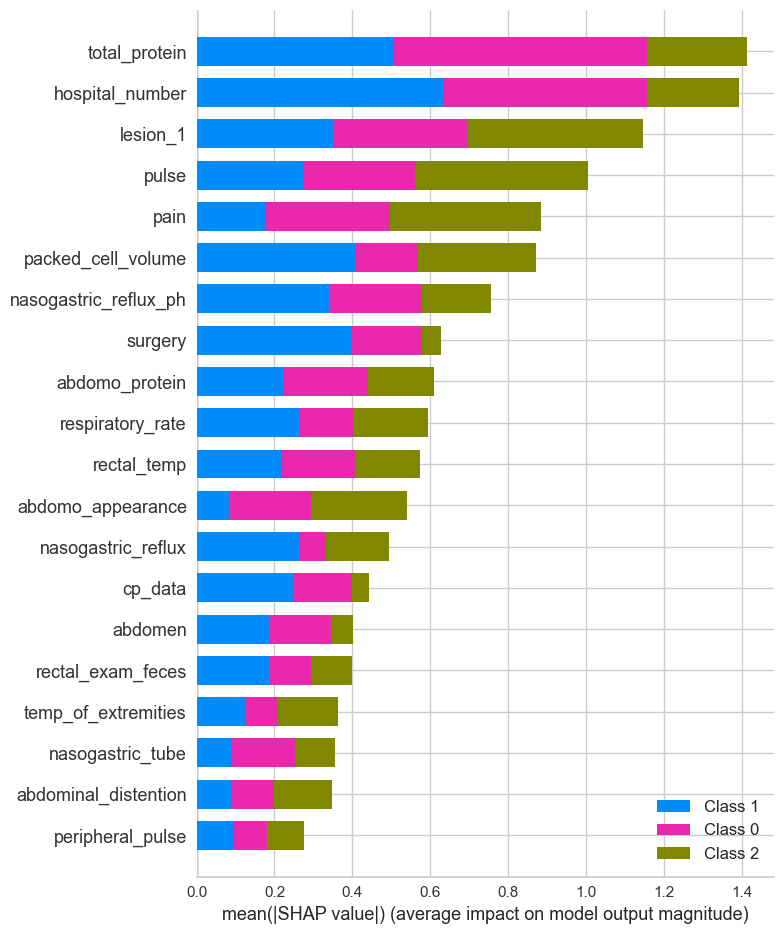

In [15]:
interpret_model(models['xgboost'])

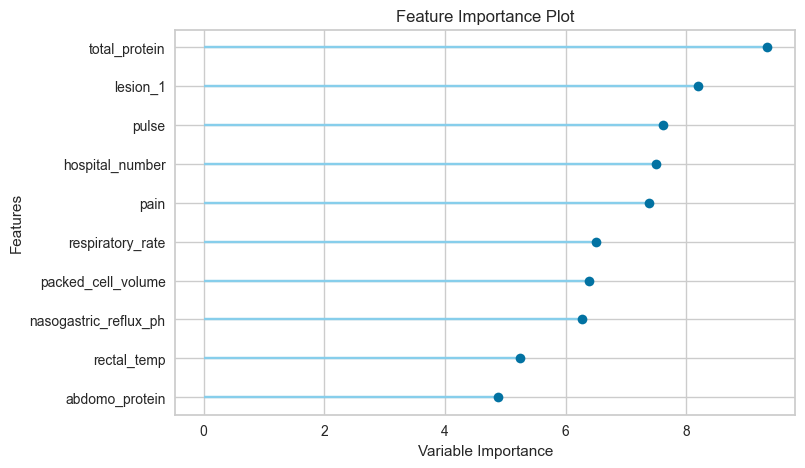

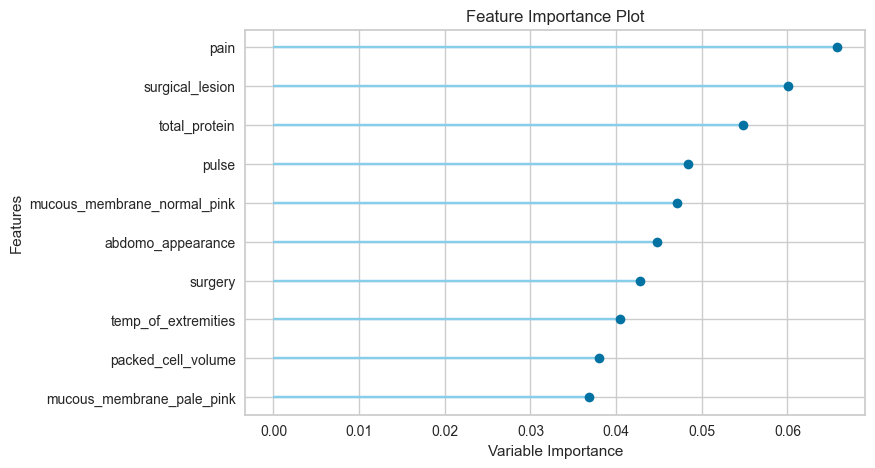

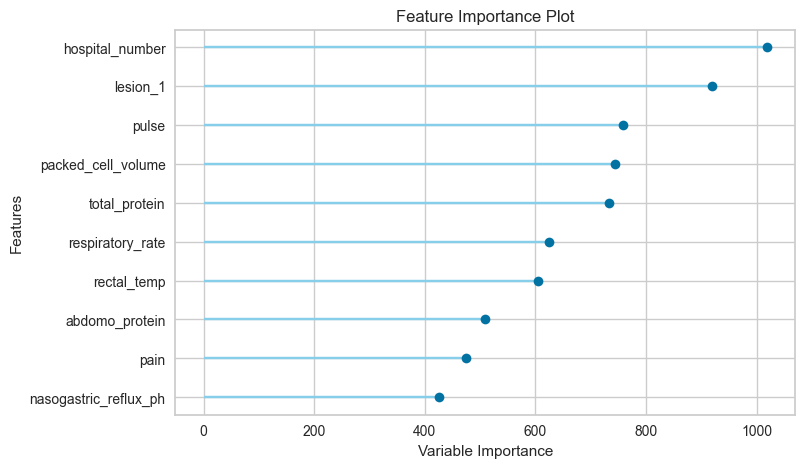

In [44]:
for model in models.values():
    plot_model(model, plot='feature')

세가지 모델에서 공통적으로 importance가 높은 Feature들은  
<font color = 'Orange'> pulse, total_protein, pain, packed_cell_volume </font>

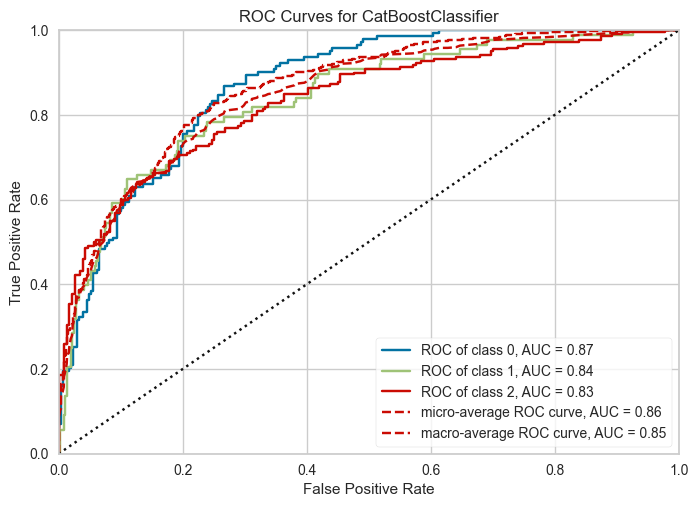

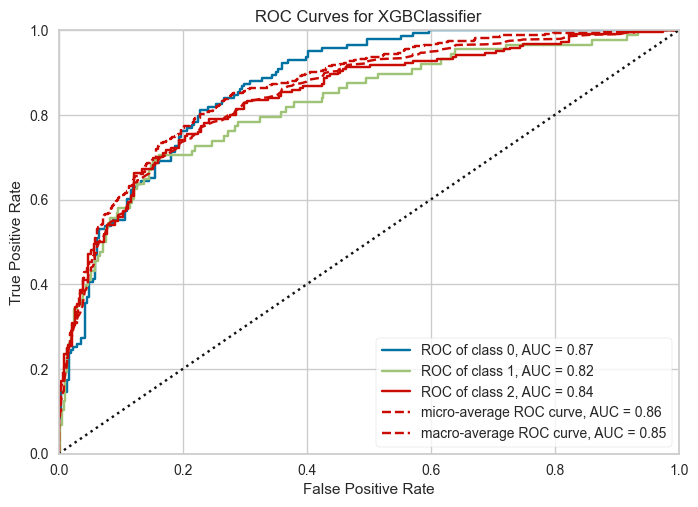

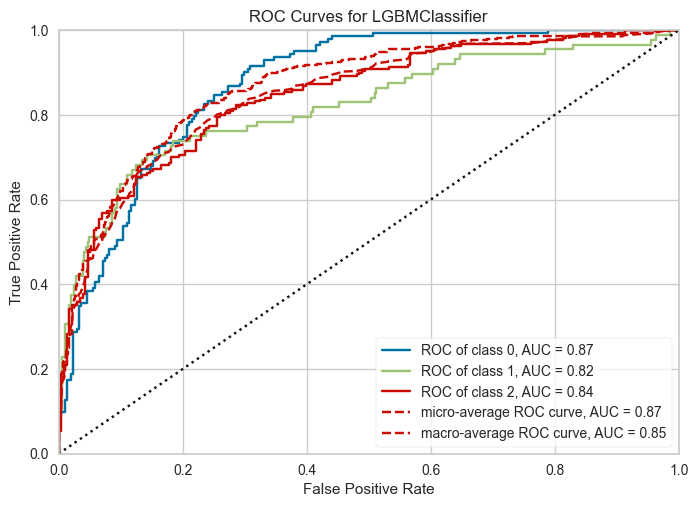

In [45]:
for model in models.values():
    plot_model(model, plot='auc')

Catboost는 세 가지 Class 모두 적절하게 예측을 잘 하는 모습.  
XGB, LGBM은 class 1 `euthanized`의 예측 능력이 다른 Class에 비해 떨어진다.

# submission
* 우선 LGBM로 제출
* 세 모델 모두 과적합이 되었음. 그나마 과적합이 덜한 LGBM으로 Baseline 선택

In [16]:
for model in models.values():
    predict_model(model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,CatBoost Classifier,0.7273,0.8655,0.7273,0.7265,0.7235,0.5513,0.5542


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.7428,0.8716,0.7428,0.7418,0.7408,0.5811,0.5826


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7561,0.8812,0.7561,0.7552,0.7536,0.6010,0.6030


[LightGBM] [Warning] feature_fraction is set=0.438555700184177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.438555700184177
[LightGBM] [Warning] bagging_fraction is set=0.8312114165823214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312114165823214
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.438555700184177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.438555700184177
[LightGBM] [Warning] bagging_fraction is set=0.8312114165823214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312114165823214
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [17]:
final_model = finalize_model(models['lightgbm'])

In [18]:
prediction = predict_model(final_model, data = test.drop('id', axis=1))

[LightGBM] [Warning] feature_fraction is set=0.438555700184177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.438555700184177
[LightGBM] [Warning] bagging_fraction is set=0.8312114165823214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312114165823214
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] feature_fraction is set=0.438555700184177, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.438555700184177
[LightGBM] [Warning] bagging_fraction is set=0.8312114165823214, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8312114165823214
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


In [19]:
prediction['id'] = test['id']
prediction

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,capillary_refill_time,pain,...,Source,mucous_membrane_bright_pink,mucous_membrane_bright_red,mucous_membrane_dark_cyanotic,mucous_membrane_normal_pink,mucous_membrane_pale_cyanotic,mucous_membrane_pale_pink,prediction_label,prediction_score,id
0,0,0,534053,38.599998,40.0,20.0,2,2,0,3,...,Test,0,0,0,1,0,0,lived,0.9321,1235
1,1,0,528469,38.200001,112.0,48.0,1,1,2,1,...,Test,1,0,0,0,0,0,died,0.5796,1236
2,1,0,528178,37.700001,66.0,12.0,1,2,0,3,...,Test,0,1,0,0,0,0,lived,0.8586,1237
3,0,0,534784,37.099998,88.0,20.0,1,1,0,1,...,Test,0,0,0,0,1,0,euthanized,0.8993,1238
4,1,0,529840,38.299999,50.0,12.0,2,2,0,3,...,Test,1,0,0,0,0,0,lived,0.8659,1239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,0,0,529461,40.299999,114.0,36.0,1,1,2,1,...,Test,0,0,0,1,0,0,died,0.6299,2054
820,1,0,535338,37.200001,100.0,20.0,1,1,2,5,...,Test,0,0,0,0,1,0,euthanized,0.6078,2055
821,1,0,529640,39.200001,132.0,12.0,1,1,2,1,...,Test,0,0,1,0,0,0,died,0.6774,2056
822,0,0,5287179,38.299999,54.0,66.0,2,2,0,3,...,Test,0,0,0,1,0,0,lived,0.9362,2057


In [20]:
sample_submission = pd.read_csv(config.SUBMISSION_FILE)
sample_submission['outcome'] = prediction['prediction_label']
sample_submission.to_csv("../output/sample_submission_V1(2nd).csv", index=False)

In [21]:
save_model(final_model, '../models/lightgbmV1(2nd)')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['surgery', 'age',
                                              'hospital_number', 'rectal_temp',
                                              'pulse', 'respiratory_rate',
                                              'temp_of_extremities',
                                              'peripheral_pulse',
                                              'capillary_refill_time',...
                                 importance_type='split',
                                 learning_rate=0.012897733176582613,
                                 max_depth=-1, min_child_samples=32,
                                 min_child_weight=0.001,

## 정리
> **Encoding**  
    `LabelEncoding` - binary feature    
    `OrdinalEncoding` - ordered feature  
    `OneHotEncoding` - else  

> **Impute**  
    `Categorical` - Mode  
    `Numerical` - Mean  

> **Feature Engineering**  
    `chi_squared_test` - drop *lesion_3*

### 모델 결과
Submission Model - LGBM (Full Dataset)  
* Train Score : 0.7381  
* Test Score : 0.7041  
* Submission Score : 0.80487  
`총평` : categorical 변수 인코딩만 잘 해줘도 score가 올라간다. 

### 다음에 해야할 것  
1. Target Encoding도 적용해보기 (Overfitting 위험)  
2. Missing Value를 다르게 Impute 해보기
3. 변수를 직접 조작해서 새로운 Feature 생성해보기 (Binning 등)  
4. Pycaret에서 과적합을 줄이는 방법 찾아보기 (Custom Parameter Setting)

## target Encoding

In [10]:
def encoder(target):
    target_map={
        "lived":0, "died": 1, "euthanized":2
    }
    return target.map(target_map)


target = 'outcome'
df_all[target] = encoder(df_all[target])

train_dum = df_all[df_all['Source'] == 'Train'].drop(['id', 'Source'], axis=1)
test_dum = df_all[df_all['Source'] == 'Test'].drop(['id', 'Source'], axis=1)
unimportant_features = []

(train_copy, test_copy) = train_dum.copy(), test_dum.copy()

for feature in categorical_cols:
    cat_labels = train_dum.groupby([feature])[target].mean().sort_values().index
    cat_labels2 = {k: i for i, k in enumerate(cat_labels, 0)}
    train_copy[feature ] = train[feature].map(cat_labels2)
    test_copy[feature] = test[feature].map(cat_labels2)

In [11]:
train_copy

,surgery,age,hospital_number,rectal_temp,pulse,respiratory_rate,temp_of_extremities,peripheral_pulse,mucous_membrane,capillary_refill_time,...,packed_cell_volume,total_protein,abdomo_appearance,abdomo_protein,surgical_lesion,lesion_1,lesion_2,lesion_3,cp_data,outcome
0,1,0,530001,38.1,132.0,24.0,2.0,2.0,4.0,2.0,...,57.0,8.5,2.0,3.4,1,2209,4,1,1,1.0
1,1,0,533836,37.5,88.0,12.0,2.0,1.0,5.0,2.0,...,33.0,64.0,2.0,2.0,1,2208,4,1,1,2.0
2,1,0,529812,38.3,120.0,28.0,2.0,2.0,2.0,0.0,...,37.0,6.4,2.0,3.4,1,5124,4,1,1,0.0
3,1,0,5262541,37.1,72.0,30.0,3.0,2.0,2.0,2.0,...,53.0,7.0,1.0,3.9,1,2208,4,1,0,0.0
4,0,0,5299629,38.0,52.0,48.0,0.0,1.0,0.0,0.0,...,47.0,7.3,1.0,2.6,0,0,4,1,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1484,0,0,533902,38.5,40.0,16.0,0.0,1.0,0.0,0.0,...,37.0,67.0,NaN,NaN,0,0,4,1,1,0.0
1485,1,0,533886,NaN,120.0,70.0,3.0,NaN,5.0,2.0,...,55.0,65.0,NaN,NaN,0,3205,4,1,1,2.0
1486,0,0,527702,37.2,72.0,24.0,2.0,0.0,5.0,2.0,...,44.0,NaN,2.0,3.3,1,2208,4,1,0,2.0
1487,1,0,529386,37.5,72.0,30.0,3.0,2.0,5.0,0.0,...,60.0,6.8,NaN,NaN,1,3205,4,1,1,1.0


In [15]:
baseline_best_model = get_pycaret_model(train_copy, "outcome")

,Description,Value
0,Session id,2477
1,Target,outcome
2,Target type,Multiclass
3,Original data shape,"(1489, 28)"
4,Transformed data shape,"(1489, 28)"
5,Transformed train set shape,"(1042, 28)"
6,Transformed test set shape,"(447, 28)"
7,Numeric features,27
8,Rows with missing values,75.8%
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.7370,0.8738,0.7370,0.7382,0.7348,0.5756,0.5773,0.3020
rf,Random Forest Classifier,0.7351,0.8698,0.7351,0.7365,0.7316,0.5700,0.5721,0.1200
lightgbm,Light Gradient Boosting Machine,0.7293,0.8670,0.7293,0.7294,0.7266,0.5605,0.5621,0.7620
et,Extra Trees Classifier,0.7102,0.8572,0.7102,0.7091,0.7049,0.5277,0.5303,0.1200
lda,Linear Discriminant Analysis,0.6785,0.8341,0.6785,0.6784,0.6725,0.4792,0.4826,0.0200
ridge,Ridge Classifier,0.6708,0.0000,0.6708,0.6650,0.6583,0.4599,0.4651,0.0160
ada,Ada Boost Classifier,0.6584,0.7776,0.6584,0.6594,0.6571,0.4502,0.4513,0.0620
dt,Decision Tree Classifier,0.6296,0.7019,0.6296,0.6309,0.6288,0.4032,0.4043,0.0200
nb,Naive Bayes,0.5211,0.7364,0.5211,0.5262,0.4612,0.1399,0.1651,0.8360
dummy,Dummy Classifier,0.4866,0.5000,0.4866,0.2368,0.3185,0.0000,0.0000,0.0160
